# Importation analysis

This notebook estimates the individual probabilities of being imported, the importation rates of the populations from Magude and Matutuine, their importation origins and a risk factor analysis. 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from genomic_tools.pairwise import high_ibd_frac_per_cat, show_ibd_frac_per_cat
from genomic_tools.pairwise import get_relatedness_origin_travels
from genomic_tools.relatedness import r_importation_prob, importation_statistics
from genomic_tools.plotting import make_pie, make_hist
from scipy.stats import chi2_contingency
from stat_tools import tables
import statsmodels.api as sm
from firthlogist import FirthLogisticRegression
from matplotlib import cm

## Importing data

We load the data to be used: 

In [2]:
#Metadata
pipeline_results_path  = "/home/apujol/isglobal/manuscripts/importation_relatedness/data/"
save_path = pipeline_results_path + "figs/"
all_data_div_covered_samples = pd.read_csv(pipeline_results_path + 'data_filtered_for_study.csv')
#Select relevant variables
metadata = all_data_div_covered_samples[['sampleID', 'nida', 'study', 'run', 'run_id_resmark', 'year', \
                                         'region', 'province', 'district', \
                                         'us', 'age', 'sex', 'parasitemia', \
                                         '1.2 Selecione o distrito do estudo.', \
                                         'date', 'pregnancy', \
                                         'occupation', 'spec_occupation', \
                                         'travel', 'travel_prov', 'travel_dist', \
                                         'Data de Ida.', 'Data de regresso', \
                                         'latitude', 'longitude', 'travel_days', \
                                         'travel_days_728', 'source']].drop_duplicates()

#Make data a temporal variable
metadata['date'] = pd.to_datetime(metadata['date'])
#Fix inconsistent values from some variables 
metadata.loc[metadata['district'].isnull(), 'district'] = metadata.loc[metadata['district'].isnull(), '1.2 Selecione o distrito do estudo.']
metadata.loc[metadata['province'] == 'Maputo Provincia', 'province'] = 'Maputo'
metadata.loc[metadata['province'] == 'Maputo Cidade', 'province'] = 'Maputo City'
metadata.loc[metadata['travel_prov'] == 'ZAMBEZIA', 'travel_prov'] = 'Zambezia'
metadata.loc[metadata['travel_prov'] == 'ZAMBEZIA (QUELIMANE)', 'travel_prov'] = 'Zambezia'
metadata.loc[metadata['travel_prov'] == 'INHAMBANE', 'travel_prov'] = 'Inhambane'
metadata.loc[metadata['travel_prov'] == 'GAZA', 'travel_prov'] = 'Gaza'
metadata.loc[metadata['travel_prov'] == 'MASSINGA', 'travel_prov'] = 'Inhambane'
metadata.loc[metadata['travel_prov'] == 'QUELIMANE', 'travel_prov'] = 'Zambezia'
metadata.loc[metadata['travel_prov'] == 'SOFALA', 'travel_prov'] = 'Sofala'
metadata.loc[metadata['travel_prov'] == 'CHIBUTO', 'travel_prov'] = 'Gaza'
metadata.loc[metadata['travel_prov'] == 'BEIRA', 'travel_prov'] = 'Sofala'
metadata.loc[metadata['travel_prov'] == 'NAMPULA', 'travel_prov'] = 'Nampula'
metadata.loc[metadata['travel_prov'] == 'MANICA', 'travel_prov'] = 'Manica'
metadata.loc[metadata['travel_prov'] == 'NIASSA', 'travel_prov'] = 'Niassa'
metadata.loc[metadata['travel_prov'] == 'MAPUTO', 'travel_prov'] = 'Maputo'
metadata.loc[metadata['travel_prov'] == 'Maputo Provincia', 'travel_prov'] = 'Maputo'
metadata.loc[metadata['travel_prov'] == 'Maputo Province', 'travel_prov'] = 'Maputo'
metadata.loc[metadata['travel_prov'] == 'Maputo Cidade', 'travel_prov'] = 'Maputo City'
metadata.loc[metadata['district'] == 'Matutine', 'district'] = 'Matutuine'

/tmp/ipykernel_30026/2191117365.py:4: DtypeWarning: Columns (12,13,15,18,19,22,24,25,28,29,30,31,32,33,34,35,39,40,41,42,43) have mixed types. Specify dtype option on import or set low_memory=False.
  all_data_div_covered_samples = pd.read_csv(pipeline_results_path + 'data_filtered_for_study.csv')


## Loading IBD results

We load the IBD results obtained from Dcifer:

In [3]:
#Path where the results are stored
ibd_data_path = pipeline_results_path
#Load results
ibd_res_filename = ibd_data_path + "ibd_results.csv"
ibd_res = pd.read_csv(ibd_res_filename)
ibd_pval_filename = ibd_data_path + "ibd_results_p_value.csv"
ibd_pval = pd.read_csv(ibd_pval_filename)
ibd_res.index = ibd_res.columns
ibd_pval.index = ibd_pval.columns

#We merge the IBD results with metadata
ibd_res_meta = pd.merge(ibd_res, metadata, left_index = True, right_on = 'sampleID', how = 'left')
ibd_pval_meta = pd.merge(ibd_pval, metadata, left_index = True, right_on = 'sampleID', how = 'left')

## Analysis

We make use of the formula from Pujol et al. 2024 to calculate the individual probabilities of being imported. For this, we need estimates of malaria transmission intensity in the different areas. We use the RDT positivity rates in children from the Mozambican Demographic Health Survey 2022-2023: 

In [4]:
#Prevalence per province from Inquérito Demográfico de Saúde 2022-2023
#Prevalência da malária em crianças
tdr_prevalence = {'Maputo' : .003, 
                  'Maputo City' : .0004, #It is officially 0.0, which was rounded to 1 digit. We assigned the higher possible prevalence to avoid collapsing probabilities 
                  'Inhambane' : .158, 
                  'Zambezia' : .349,
                  'Sofala' : .332, 
                  'Manica' : .102, 
                  'Tete' : .195, 
                  'Niassa' : .338, 
                  'Cabo Delgado' : .381, 
                  'Nampula' : .547, 
                  'Gaza' : .057}


We now define a mask to select our study cases: 

In [5]:
react_mask = (metadata['source'] == 'REACT2')&(ibd_res_meta['province'] == 'Maputo')
react_meta = (react_mask)&metadata['travel'].notnull()&((metadata['district'] == 'Matutuine') | (metadata['district'] == 'Magude'))
print("Total number of Dense sampling participants with metadata:", np.sum(react_meta))

Total number of Dense sampling participants with metadata: 207


In [6]:
travelled_ds = react_meta&metadata['travel_prov'].notnull()
print("Total number of Dense sampling participants:", np.sum(travelled_ds))

Total number of Dense sampling participants: 107


We now calculate, for each study case, the genetic relatedness of its sample with the local (Maputo) and travel destination populations. This relatedness is defined as the number of samples that have an IBD>0.1 and p<0.05 with the studied sample. 

In [7]:
#Calculating all relatedness fractions with origin and destination populations
ibd_res_meta, ibd_pval_meta = get_relatedness_origin_travels(ibd_res_meta, ibd_pval_meta, ibd_threshold = 0.1, p_value = 0.05)
#Filling missing data of relatedness at destiny with relatedness at origin, so that both probabilities are equal
ibd_res_meta.loc[ibd_res_meta['rel_dest1'].isnull(), 'rel_dest1'] = ibd_res_meta.loc[ibd_res_meta['rel_dest1'].isnull(), 'rel_origin']
ibd_pval_meta.loc[ibd_pval_meta['rel_dest1'].isnull(), 'rel_dest1'] = ibd_pval_meta.loc[ibd_pval_meta['rel_dest1'].isnull(), 'rel_origin']
#Renormalising when relatedness is 0 for both origin and destination
mask2renorm = (ibd_res_meta['rel_dest1'] == 0)&(ibd_res_meta['rel_origin'] == 0)
ibd_res_meta.loc[mask2renorm, 'rel_origin'] = .00001
ibd_res_meta.loc[mask2renorm, 'rel_dest1'] = .00001
mask2renorm = (ibd_pval_meta['rel_dest1'] == 0)&(ibd_pval_meta['rel_origin'] == 0)
ibd_pval_meta.loc[mask2renorm, 'rel_origin'] = .00001
ibd_pval_meta.loc[mask2renorm, 'rel_dest1'] = .00001

ibd_res_meta['travel_prov2'] = np.nan
ibd_res_meta['rel_dest2'] = np.nan
ibd_pval_meta['travel_prov2'] = np.nan
ibd_pval_meta['rel_dest2'] = np.nan

/home/apujol/anaconda3/envs/pyspatial/lib/python3.9/site-packages/genomic_tools-1.0-py3.9.egg/genomic_tools/pairwise.py:801: RuntimeWarning: Mean of empty slice.
/home/apujol/anaconda3/envs/pyspatial/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/apujol/anaconda3/envs/pyspatial/lib/python3.9/site-packages/genomic_tools-1.0-py3.9.egg/genomic_tools/pairwise.py:801: RuntimeWarning: Mean of empty slice.
/home/apujol/anaconda3/envs/pyspatial/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Here we assign to each case the transmission intensity (RDT positivity rates) at origin and at travel destination provinces: 

In [8]:
#Define prevalences of origin and travel destinations
ibd_res_meta['origin_PR'] = pd.Series(dtype = float)
ibd_res_meta['dest_PR'] = pd.Series(dtype = float)

for i in ibd_res_meta['travel_prov'].index: 
    if type(ibd_res_meta.loc[i, 'travel_prov']) is str:
        ibd_res_meta.loc[i, 'dest_PR'] = tdr_prevalence[ibd_res_meta.loc[i, 'travel_prov']]
    if type(ibd_res_meta.loc[i, 'province']) is str:
        ibd_res_meta.loc[i, 'origin_PR'] = tdr_prevalence[ibd_res_meta.loc[i, 'province']]
    

We will use the travel time (number of days of travel) in the equation. When this information is missing, we will impute it from the mean travel durations available: 

In [9]:
print("Mean travel time:", ibd_res_meta['travel_days_728'].mean())
ibd_res_meta.loc[ibd_res_meta['travel_days_728'].isnull()&travelled_ds, 'travel_days_728'] = ibd_res_meta['travel_days_728'].mean()

Mean travel time: 9.138461538461538


We are ready to calculate the probability of importation for all studied cases: 

In [10]:
#Obtain importation probabilities using imputed travel time
#Defining RxTxPR variables
ibd_res_meta['rel_dest1xTimp'] = ibd_res_meta['rel_dest1']*ibd_res_meta['travel_days_728']
ibd_res_meta['rel_origxTimp'] = ibd_res_meta['rel_origin']*(21-ibd_res_meta['travel_days_728'])
ibd_res_meta.loc[ibd_res_meta['rel_origxTimp']<0, 'rel_origxTimp'] = 0
ibd_res_meta['rel_dest1xTimpxPR'] = ibd_res_meta['rel_dest1xTimp']*ibd_res_meta['dest_PR']
ibd_res_meta['rel_origxTimpxPR'] = ibd_res_meta['rel_origxTimp']*ibd_res_meta['origin_PR']
#Obtaining importation probabilities
ibd_res_meta = r_importation_prob(ibd_res_meta, r_origin = 'rel_origxTimpxPR', \
                                  r_des1 = 'rel_dest1xTimpxPR', class_name = 'prob_imp_timp_pr')

We now produce a table of importation rates in the population, obtained as the weighted sum of all probabilities: 

In [11]:
#Counting the total number of studies cases and those who travelles
mask = travelled_ds
total_ds_data = react_meta.sum()
total_reported_travel = np.sum(travelled_ds)

#Calculating importation statistics
imported_stats_t = importation_statistics(ibd_res_meta[mask], \
                                          rel_origin = 'rel_origin', 
                                          rel_dest1 = 'rel_dest1', 
                                         prob_imported = 'prob_imp_timp_pr')
print("Total weighted number of imported cases by destination from Dense Sampling only")
imported_stats_t["% all reported"] = imported_stats_t["N. cases"]/total_ds_data*100
#Showing table of results
imported_stats_t

Total weighted number of imported cases by destination from Dense Sampling only


/tmp/ipykernel_30026/1532213685.py:7: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  imported_stats_t = importation_statistics(ibd_res_meta[mask], \
/home/apujol/anaconda3/envs/pyspatial/lib/python3.9/site-packages/genomic_tools-1.0-py3.9.egg/genomic_tools/relatedness.py:354: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/apujol/anaconda3/envs/pyspatial/lib/python3.9/site-packages/genomic_tools-1.0-py3.9.egg/genomic_tools/relatedness.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ve

,N. cases,% cases,% all reported
Cabo Delgado,0.997873,0.932592,0.482064
Gaza,11.309219,10.569363,5.463391
Inhambane,53.091616,49.618332,25.648124
Manica,0.883280,0.825495,0.426705
Maputo,2.734066,2.555202,1.320805
Maputo City,0.000000,0.000000,0.000000
Nampula,4.982831,4.656852,2.407165
Sofala,0.985034,0.920592,0.475862
Zambezia,11.877553,11.100517,5.737948
Total,86.861472,81.178945,41.962064


Here we obtain the importation statistics once cases are classified as local or imported based on P(Imported)>0.5:

In [12]:
imported = ibd_res_meta['prob_imp_timp_pr'] > .5
ibd_res_meta['imported'] = pd.Series(dtype = int)
ibd_res_meta.loc[imported, 'imported'] = 1
ibd_res_meta.loc[np.invert(imported), 'imported'] = 0


mask = travelled_ds
total_ds_data = react_meta.sum()
total_reported_travel = np.sum(travelled_ds)

imported_stats_t = importation_statistics(ibd_res_meta[mask], \
                                          rel_origin = 'rel_origin', 
                                          rel_dest1 = 'rel_dest1', 
                                         prob_imported = 'imported')
print("Total weighted number of imported cases by destination from Dense Sampling only")
imported_stats_t["% all reported"] = imported_stats_t["N. cases"]/total_ds_data*100
imported_stats_t

Total weighted number of imported cases by destination from Dense Sampling only


/tmp/ipykernel_30026/3370145833.py:11: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  imported_stats_t = importation_statistics(ibd_res_meta[mask], \
/home/apujol/anaconda3/envs/pyspatial/lib/python3.9/site-packages/genomic_tools-1.0-py3.9.egg/genomic_tools/relatedness.py:354: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/apujol/anaconda3/envs/pyspatial/lib/python3.9/site-packages/genomic_tools-1.0-py3.9.egg/genomic_tools/relatedness.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-v

,N. cases,% cases,% all reported
Cabo Delgado,1.0,0.934579,0.483092
Gaza,12.0,11.214953,5.797101
Inhambane,55.0,51.401869,26.570048
Manica,1.0,0.934579,0.483092
Maputo,1.0,0.934579,0.483092
Maputo City,0.0,0.000000,0.000000
Nampula,5.0,4.672897,2.415459
Sofala,1.0,0.934579,0.483092
Zambezia,12.0,11.214953,5.797101
Total,88.0,82.242991,42.512077


Now we obtain the same tables for Magude and Matutuine separately: 

In [13]:
#Counting the total number of studies cases and those who travelled
for dist in ['Magude', 'Matutuine']:
    print(dist)
    #Weighted sum of probabilities
    mask = travelled_ds&(ibd_res_meta['district'] == dist)
    total_ds_data = np.sum(ibd_res_meta['district'] == dist)
    total_reported_travel = np.sum(travelled_ds&(ibd_res_meta['district'] == dist))
    
    #Calculating importation statistics
    imported_stats_t = importation_statistics(ibd_res_meta[mask], \
                                              rel_origin = 'rel_origin', 
                                              rel_dest1 = 'rel_dest1', 
                                             prob_imported = 'prob_imp_timp_pr')
    imported_stats_t["% all reported"] = imported_stats_t["N. cases"]/total_ds_data*100
    #Showing table of results
    print(imported_stats_t)
    
    #Defining imported as P(Imp)>.5
    imported = ibd_res_meta['prob_imp_timp_pr'] > .5
    ibd_res_meta['imported'] = pd.Series(dtype = int)
    ibd_res_meta.loc[imported, 'imported'] = 1
    ibd_res_meta.loc[np.invert(imported), 'imported'] = 0
    
    imported_stats_t = importation_statistics(ibd_res_meta[mask], \
                                              rel_origin = 'rel_origin', 
                                              rel_dest1 = 'rel_dest1', 
                                             prob_imported = 'imported')
    imported_stats_t["% all reported"] = imported_stats_t["N. cases"]/total_ds_data*100
    print(imported_stats_t)

Magude
           N. cases    % cases  % all reported
Gaza       1.930544  64.351470        6.032950
Inhambane  0.980835  32.694484        3.065108
Total      2.911379  97.045954        9.098058
           N. cases     % cases  % all reported
Gaza            2.0   66.666667           6.250
Inhambane       1.0   33.333333           3.125
Total           3.0  100.000000           9.375
Matutuine
               N. cases    % cases  % all reported
Cabo Delgado   0.997873   0.959494        0.557471
Gaza           9.378675   9.017956        5.239483
Inhambane     52.110781  50.106520       29.112168
Manica         0.883280   0.849308        0.493453
Maputo         2.734066   2.628910        1.527411
Maputo City    0.000000   0.000000        0.000000
Nampula        4.982831   4.791184        2.783705
Sofala         0.985034   0.947148        0.550298
Zambezia      11.877553  11.420724        6.635504
Total         83.950093  80.721243       46.899493


/tmp/ipykernel_30026/54184629.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  imported_stats_t = importation_statistics(ibd_res_meta[mask], \
/home/apujol/anaconda3/envs/pyspatial/lib/python3.9/site-packages/genomic_tools-1.0-py3.9.egg/genomic_tools/relatedness.py:354: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/apujol/anaconda3/envs/pyspatial/lib/python3.9/site-packages/genomic_tools-1.0-py3.9.egg/genomic_tools/relatedness.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

              N. cases    % cases  % all reported
Cabo Delgado       1.0   0.961538        0.558659
Gaza              10.0   9.615385        5.586592
Inhambane         54.0  51.923077       30.167598
Manica             1.0   0.961538        0.558659
Maputo             1.0   0.961538        0.558659
Maputo City        0.0   0.000000        0.000000
Nampula            5.0   4.807692        2.793296
Sofala             1.0   0.961538        0.558659
Zambezia          12.0  11.538462        6.703911
Total             85.0  81.730769       47.486034


/tmp/ipykernel_30026/54184629.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  imported_stats_t = importation_statistics(ibd_res_meta[mask], \
/home/apujol/anaconda3/envs/pyspatial/lib/python3.9/site-packages/genomic_tools-1.0-py3.9.egg/genomic_tools/relatedness.py:354: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/home/apujol/anaconda3/envs/pyspatial/lib/python3.9/site-packages/genomic_tools-1.0-py3.9.egg/genomic_tools/relatedness.py:358: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-ver

Here we visualise the distribution of importation probabilities from the populations of Magude and Matutuine: 

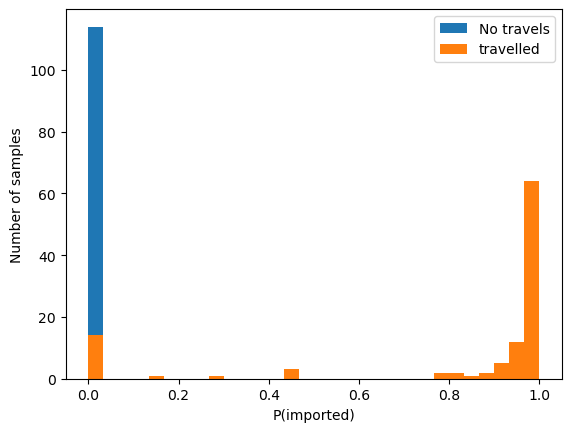

Total number of importations from probabilistic approach with imputed time and prevalence:
86.86 -- 83.52 % of cases reporting travel
48.53 % of cases with data


In [14]:
nbins = 30
plt.hist(ibd_res_meta['prob_imp_timp_pr'][react_meta], \
         nbins, range = [0,1], label = 'No travels')
plt.hist(ibd_res_meta['prob_imp_timp_pr'][travelled_ds], nbins, range = [0,1], label = 'travelled', alpha = 1)
plt.legend()
plt.xlabel("P(imported)")
plt.ylabel("Number of samples")
#plt.savefig(save_path + "P_imp_distr.png")
#plt.savefig(save_path + "P_imp_distr.pdf")
plt.show()


print("Total number of importations from probabilistic approach with imputed time and prevalence:")
total = np.sum(ibd_res_meta['prob_imp_timp_pr'][travelled_ds])
print(round(total, 2), '--', round(total/total_reported_travel*100, 2), '% of cases reporting travel')
print(round(total/total_ds_data*100, 2), '% of cases with data')


## Statistical tests

In the following sections we conduct some statistical analyses. First, we define a new data frame with the relevant data of the study cases: 

In [15]:
#Creating the data to be used
import_data = ibd_res_meta.loc[react_meta, ['sampleID', 'nida', 'district', \
                                            'run_id_resmark', 'run', 'us', 'age', 'sex', 'date', 'pregnancy', \
                                            'occupation', 'spec_occupation', 'travel', \
                                            'travel_prov', 'travel_dist', \
                                            'travel_days_728', 'prob_imp_timp_pr']]
#Create variable season
import_data['season'] = 'rainy'
import_data.loc[import_data['date'] > '2022-06-01', 'season'] = 'dry'

#Creating a simplified version of occupation for proper statistics
import_data['occupation_simp'] = import_data['occupation']
mask_occ = import_data['occupation_simp'].notnull()
for occ in ['Domestica', 'Estudante', 'Agricultor', 'Nao aplicavel']:
    mask_occ[import_data['occupation_simp'] == occ] = False
import_data.loc[mask_occ, 'occupation_simp'] = 'Other'

In order to assess the potential impact of the main importation source, Inhambane, to the overall transmission in Maputo province, we estimate the fraction of samples from Maputo that are more genetically related to Inhambane that to Maputo. For this, we calculate the genetic relatedness of all the studied samples with both Maputo and Inhambane populations.

In [16]:
#Define input data
mask = react_meta
traveled_samples = list(ibd_res_meta[mask]['sampleID'])
destiny_samples = list(['Inhambane']*len(traveled_samples))
province_samples = list(ibd_res_meta[mask]['province'])
orig_dest_travels = [str(province_samples[i]) + '->' + str(destiny_samples[i]) \
                     for i in range(len(destiny_samples))]

#Define thresholds of relatedness
max_p = .05
min_IBD = 0.1

#Defining categories to use
category_label2 = 'province'
category_label = 'sampleID'
categories2 = ['Maputo', 'Inhambane', 'Sofala', 'Manica', \
               'Tete', 'Zambezia', 'Nampula', 'Niassa', 'Cabo Delgado']
categories = traveled_samples

#Calculating fraction of related pairs
ibdfrac_per_cat, ibdfrac_pval_per_cat, overall_high_ibd_frac = high_ibd_frac_per_cat(ibd_res, ibd_res_meta, category_label, \
                                                                                     category_label2, \
                                                                                     all_p_res = ibd_pval, ibd_pval_meta = ibd_pval_meta, \
                                                                                     min_IBD = min_IBD, max_p = max_p, \
                                                                                     categories = categories, categories2 = categories2, \
                                                                                     verbose = True, perm_pval = False)

/tmp/ipykernel_30026/620041788.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  traveled_samples = list(ibd_res_meta[mask]['sampleID'])
/tmp/ipykernel_30026/620041788.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  province_samples = list(ibd_res_meta[mask]['province'])


Overall fraction of pairs with IBD >= 0.1 and p<= 0.05: 0.033748184056991475


In [17]:
ibdfrac_per_cat

,N1852388_1_S78,N1852392_8_S137_L001,N1922384_1_S4_L001,N1922396_4_S161_L001,N1922411_4_S134_L001,N1922431_2_S97_L001,N1922467_1_S3,N1922471_8_S285_L001,N1922491_6_S168,N1922495_4_S274,...,N2039552_S167,N2039568_1_S251_L001,N2039678_7_S202,N2039681_7_S123_L001,N2084421_9_S262,N2084423_3_S270,N2084424_S164,N2084428_8_S170,N2084593_3_S172,N2084595_7_S278
Maputo,0.042654,0.025276,0.018957,0.031596,0.044234,0.022117,0.009479,0.025276,0.048973,0.006319,...,0.026856,0.022117,0.037915,0.015798,0.012638,0.034755,0.015798,0.015798,0.039494,0.011058
Inhambane,0.030137,0.016438,0.027397,0.038356,0.060274,0.008219,0.024658,0.024658,0.068493,0.021918,...,0.027397,0.005479,0.063014,0.041096,0.008219,0.027397,0.000000,0.035616,0.027397,0.008219
Sofala,0.024390,0.024390,0.012195,0.000000,0.012195,0.000000,0.012195,0.024390,0.012195,0.024390,...,0.012195,0.024390,0.000000,0.000000,0.000000,0.024390,0.060976,0.036585,0.012195,0.012195
Manica,0.101266,0.113924,0.000000,0.012658,0.037975,0.025316,0.000000,0.101266,0.025316,0.000000,...,0.063291,0.012658,0.012658,0.025316,0.000000,0.063291,0.025316,0.012658,0.050633,0.000000
Tete,0.021053,0.021053,0.021053,0.010526,0.000000,0.031579,0.010526,0.021053,0.031579,0.000000,...,0.021053,0.021053,0.000000,0.010526,0.000000,0.010526,0.031579,0.021053,0.010526,0.052632
Zambezia,0.012048,0.072289,0.024096,0.000000,0.012048,0.048193,0.000000,0.012048,0.012048,0.012048,...,0.060241,0.024096,0.000000,0.024096,0.000000,0.048193,0.072289,0.048193,0.036145,0.012048
Nampula,0.011111,0.055556,0.033333,0.000000,0.011111,0.044444,0.000000,0.000000,0.011111,0.000000,...,0.022222,0.022222,0.000000,0.011111,0.000000,0.055556,0.066667,0.000000,0.044444,0.022222
Niassa,0.023256,0.011628,0.011628,0.011628,0.000000,0.046512,0.011628,0.011628,0.023256,0.011628,...,0.104651,0.011628,0.000000,0.000000,0.000000,0.046512,0.046512,0.000000,0.023256,0.011628
Cabo Delgado,0.022727,0.045455,0.034091,0.000000,0.000000,0.011364,0.000000,0.022727,0.000000,0.000000,...,0.034091,0.011364,0.000000,0.022727,0.000000,0.022727,0.068182,0.011364,0.011364,0.000000


Showing results of the statistics: 

In [18]:
#Fraction of cases with IBD larger with local population than with Inhambane
print("Fraction of cases with IBD larger with local population than with Inhambane")
print(np.mean(ibdfrac_per_cat.loc['Maputo'] - ibdfrac_per_cat.loc['Inhambane'] > 0))
print("Number of cases with IBD larger with local population than with Inhambane")
print(np.sum(ibdfrac_per_cat.loc['Maputo'] - ibdfrac_per_cat.loc['Inhambane'] > 0))

Fraction of cases with IBD larger with local population than with Inhambane
0.391304347826087
Number of cases with IBD larger with local population than with Inhambane
81


Now, we want to analyse if the genetic relatedness of samples with travel reports is higher with the population from their travel destination or with the population from Maputo province (local). For this, we first create variables specifying if the sample is more genetically related with Maputo or with each of the other provinces: 

In [19]:
#Generating variables specifying if a sample has higher IBD with another province than with Maputo
data_local_vs_imps = pd.DataFrame({'sampleID' : traveled_samples})
for prov in categories2:
    data_local_vs_imps['est_imp_'+prov] = np.array(ibdfrac_per_cat.loc['Maputo'] - ibdfrac_per_cat.loc[prov] < 0, dtype = int)

Now we merge this information and define new variables to specify the travel destinations and the genetic relatedness comparison between Maputo province and the travel destination: 

In [20]:
#Merging data with travel reports and creating variables to select samples from each travel destination
trav_ibdcomp = pd.merge(import_data[['sampleID', 'travel', 'travel_prov']], data_local_vs_imps, \
         on = 'sampleID', how = 'left')

for prov in categories2:
    trav_ibdcomp['travel_' + prov] = trav_ibdcomp['travel_prov'] == prov

We now run the statistical analysis, where we compare the travel reports with their origin-destination genetic relatedness and obtain a Chi square contingency test to assess whether there is a significant correlation between travel reports and genetic relatedness with the populations at origin and travel destinations: 

In [22]:
#Factor analysis to associate travel destinations with IBD comparisons
all_tables = []
for prov in categories2:
    print(prov)
    table_trav_imp = tables.labels_2d(trav_ibdcomp, 'travel_' + prov, 'est_imp_'+prov)
    print(table_trav_imp)
    stat, p, dof, expected = chi2_contingency(table_trav_imp)
    print("p-value:", p)
    print()
    print("-------")
    print()
    all_tables.append(table_trav_imp)
    

Maputo
         0
False  197
True    10
p-value: 1.0

-------

Inhambane
        1   0
False  78  70
True   48  11
p-value: 0.00025673628082687497

-------

Sofala
           0     1
False  133.0  73.0
True     1.0   0.0
p-value: 1.0

-------

Manica
           0     1
False  140.0  66.0
True     0.0   1.0
p-value: 0.7055914178487008

-------

Tete
         0   1
False  153  54
p-value: 1.0

-------

Zambezia
         0   1
False  126  66
True     8   7
p-value: 0.49712492863755875

-------

Nampula
         0   1
False  134  68
True     1   4
p-value: 0.09418103385846419

-------

Niassa
         0   1
False  138  69
p-value: 1.0

-------

Cabo Delgado
           0     1
False  137.0  69.0
True     0.0   1.0
p-value: 0.731662060369097

-------



## Importation factor analysis

We finally conduct risk-factor analyses to find associations between different factors and importation or travel. We use Firth's logistic regression to obtain the significance of each factor, first in a univariate approach, and finally in a multivariate approach. 

## Loading lab data with parasitemia

We include molecular data in the analysis. Here we load and merge the data on parasitemia

In [23]:
#Load data on parasitemia
parasitemia_filename = "/home/apujol/isglobal/projects/genmoz/data/GenMoz_LAB_DB_280824_HFS_TES_REACT.xlsx"
lab_data_parasitemia = pd.read_excel(parasitemia_filename)
#Select data to use
study_mask = (lab_data_parasitemia['STUDY'] == 'HFS_2022') | (lab_data_parasitemia['STUDY'] == 'HFS22') | (lab_data_parasitemia['STUDY'] == 'TES22') | (lab_data_parasitemia['STUDY'] == 'REACT2')
lab_data_parasitemia_filt = lab_data_parasitemia[study_mask]
#pre-process and clean data
lab_data_parasitemia_filt = lab_data_parasitemia_filt[lab_data_parasitemia_filt['PARASITEMIA'].astype(float) > 0]
lab_data_parasitemia_filt = lab_data_parasitemia_filt[['SAMPLE.ID', 'PARASITEMIA', 'RUN', 'RUN2', 'RUN3', 'RUN4', 'RUN5']].drop_duplicates()
dup_samples = lab_data_parasitemia_filt.loc[lab_data_parasitemia_filt['SAMPLE.ID'].duplicated(), 'SAMPLE.ID']

In case of duplicates, we keep the right one according to our sequencing prodecures, which correspond to those with highest parasitemia

In [24]:
#In case of duplicate samples, we choose the highest parasitemia. 
#We checked this gets the ones we really used
dup_samples = lab_data_parasitemia_filt.loc[lab_data_parasitemia_filt['SAMPLE.ID'].duplicated(), 'SAMPLE.ID']
for s in dup_samples:
    if str(s)[-2] == '.':
        mask = lab_data_parasitemia_filt['SAMPLE.ID'] == s
        max_density = np.max(lab_data_parasitemia_filt.loc[mask, 'PARASITEMIA'].astype(float))
        lab_data_parasitemia_filt.loc[mask, 'PARASITEMIA'] = max_density
        
lab_data_parasitemia_filt = lab_data_parasitemia_filt[['SAMPLE.ID', 'PARASITEMIA']].drop_duplicates()

We merge this information with our data frame

In [25]:
import_data['nida_obj'] = import_data['nida'].astype(str).astype(object)
import_data = pd.merge(import_data, lab_data_parasitemia_filt, left_on = 'nida_obj', right_on = 'SAMPLE.ID', how = 'left')
import_data['logdens'] = np.log10(import_data['PARASITEMIA'].astype(float))

We also load and merge the data with estimates of polyclonality and complexity of infection obtained from MOIRE

In [26]:
#Load data
data_path  = pipeline_results_path
eff_coi = pd.read_csv(data_path + "eff_coi.csv")
naive_coi = pd.read_csv(data_path + "naive_coi.csv")

#Merge data
import_data = pd.merge(import_data, eff_coi[['sample_id', 'post_effective_coi_mean']], \
         left_on = 'sampleID', right_on = 'sample_id', how = 'left')
#Rename, create new variables
import_data['eCOI'] = import_data['post_effective_coi_mean']
import_data['polyclonal'] = pd.Series(import_data['post_effective_coi_mean'] > 1.1, dtype = int)
import_data = import_data.rename(columns = {'sample_id_x' : 'sample_id'})
import_data = pd.merge(import_data, naive_coi[['sample_id', 'naive_coi', 'prob_polyclonal']], \
         left_on = 'sampleID', right_on = 'sample_id', how = 'left')
import_data['naive_polyclonal'] = pd.Series(import_data['naive_coi'] > 1, dtype = int)

We now define categorical ages

In [27]:
import_data['age_cat'] = pd.Series([])
import_data.loc[import_data['age'] >= 18, 'age_cat'] = 'Adult'
import_data.loc[import_data['age'] < 18, 'age_cat'] = 'Minor'

Finally, we define cases as imported if their probability of being imported is >0.5

In [28]:
imported = import_data['prob_imp_timp_pr'] > .5
import_data['imported'] = pd.Series(dtype = int)
import_data.loc[imported, 'imported'] = 1
import_data.loc[np.invert(imported), 'imported'] = 0

We set the list of factors to include in the analysis

In [29]:
factor_list = ['district', 'season', 'us', 'sex', 'pregnancy', 'occupation_simp', \
               'travel_prov', 'age_cat', 'logdens', 'eCOI', 'polyclonal', 'naive_coi', \
               'prob_polyclonal', 'naive_polyclonal']

### Firth logistic regressions

To obtain the odds ratios from Firth's logistic regressions, we define the following functions, which will be used in the analysis:

In [30]:
def set_x_for_firth_logist_reg(data, factor, data_type = 'categorical', verbose = True, \
                              feature_ref = None):
    """
    This method returns the predictor variables for a firth logistic regression. 
    
    Parameters:
    -----------
    data: pd.DataFrame
        The dataframe used for the firth regression. 
    factor: str or list
        The name (univariate analysis) or list of names (for a multivariate
        analysis) of the variables from data to be included in the firth 
        logistic regression. 
    data_type: str or list
        The type (for a univariate analysis) or list of types (for a 
        multivariate analysis) of the data variables. They can be 
        categorical ('categ' or 'categorical') or continuous ('cont' 
        or 'continuous'). 
    verbose: bool
        If True, some text is printed in the process. 
    feature_ref: str or list
        The name (univariate analysis) or list of names (for a multivariate
        analysis) of the feature of each variable to be used as reference in 
        the firth logistic regression. 
    
    Returns:
    --------
    x: np.array
        An array of the predictor variables for the fith logistic regression. 
    feature_names: list
        The list of variable names to be shown in the modelling output. 
    """
    if (type(factor) is str) & (type(data_type) is str):
        if data_type in ['categ', 'categorical']: 
            if feature_ref is None:
                feature_names = data[factor].unique()[:-1].tolist()
                ref_name = data[factor].unique()[-1]
            elif (type(feature_ref) is str) or np.isfinite(feature_ref):
                all_feature_names = data[factor].unique()
                feature_names = all_feature_names[all_feature_names != feature_ref].tolist() #TODO test
                ref_name = feature_ref
            else: 
                print("WARNING: wrong type of feature_ref", type(feature_ref), factor)
                print("feature_ref not used")
                pdb.set_trace()
                feature_names = data[factor].unique()[:-1].tolist()
                ref_name = data[factor].unique()[-1]
            if verbose: 
                print("Reference value:", ref_name)
            xlist = []
            for feature in feature_names:
                xlist.append(data[factor] == feature)
                x = np.array(xlist).T
        elif data_type in ['continuous', 'cont']:
            feature_names = [factor]
            x = np.array([data[factor]]).T
    elif (type(factor) is list) & (type(data_type) is list):
        x, feature_names = set_x_for_multi_firth_logist_reg(data, factor, data_type, \
                                                            feature_refs = feature_ref)
    else: 
        print("ERROR: wrong format of factor and data_type:", type(factor), type(data_type))
        return 1
    return x, feature_names

In [31]:
def set_x_for_multi_firth_logist_reg(data, factor_list, data_types, feature_refs = None):
    """
    This method returns the predictor variables and names for a multivariate firth 
    logistic regression. 
    
    Parameters:
    -----------
    data: pd.DataFrame
        The dataframe used for the firth regression. 
    factor_list: list
        The list of names of the variables from data to be included in the 
        multivariate firth logistic regression. 
    data_types: list
        The list of types of the data variables. They can be categorical 
        ('categ' or 'categorical') or continuous ('cont' or 'continuous'). 
    feature_refs: list
        list of the features to be used as reference for each factor. 
    
    Returns:
    --------
    x: np.array
        An array of the predictor variables for the fith logistic regression. 
    feature_names: list
        The list of variable names to be shown in the modelling output. 
    """
    feature_ref = None
    if feature_refs is not None:
        feature_ref = feature_refs[0]
    x, feature_names = set_x_for_firth_logist_reg(data, factor_list[0], data_type = data_types[0], \
                                                 feature_ref = feature_ref)
    for i, factor in enumerate(factor_list_multi[1:]): 
        feature_ref = None
        if feature_refs is not None:
            feature_ref = feature_refs[i + 1]
        x2, feature_names2 = set_x_for_firth_logist_reg(data, factor, data_type = data_types[i + 1], \
                                                       feature_ref = feature_ref)
        x = np.concatenate((x, x2), axis = 1)
        feature_names = feature_names + feature_names2
    return x, feature_names

In [32]:
def firth_logist_reg(data, x, y, data_type = 'categorical', verbose = False, clean_data = True, \
                    feature_ref = None):
    """
    This method performs a univariate or multivariate firth logistic regression and returns 
    the odds ratio and p-value statistics. 
    
    Parameters: 
    -----------
    data: pd.DataFrame
        The dataframe used for the firth regression.
    x: str or list
        The name (univariate analysis) or list of names (for a multivariate
        analysis) of the predictor variables from data to be included in the firth 
        logistic regression. 
    data_type: str or list
        The type (for a univariate analysis) or list of types (for a multivariate analysis) 
        of the predictor variables. They can be categorical ('categ' or 'categorical') or 
        continuous ('cont' or 'continuous'). 
    y: str
        The name of the variable from data to be used as response variable. 
    verbose: bool
        If True, if prints the output of the model. 
    clean_data: bool
        If True, the data is cleaned to that only data without missings is included. This is 
        only implemented for the univariate analysis, so previous cleaning needs to be 
        performed beforehand for a multivariate analysis. 
    feature_ref: str or list
        The name (univariate analysis) or list of names (for a multivariate
        analysis) of the feature of each variable to be used as reference in 
        the firth logistic regression. 
        
    Returns:
    --------
    odds_ratio: np.array
        An array with all the odd ratios obtained. 
    odds_ci: np.array
        An 2D-array with all the CI of the odd ratios obtained. 
    p_vals: np.array
        An array with all the p-values obtained. 
    feature_names: list
        A list of the feature names corresponding to the obtained statistics.
    """
    fl = FirthLogisticRegression()
    if clean_data:
        data_mask = data[y].notnull()&data[x].notnull()
        data_f = data[data_mask]
    else: 
        data_f = data
    y = data_f[y]
    x, feature_names = set_x_for_firth_logist_reg(data_f, x, data_type = data_type, \
                                                  verbose = verbose, feature_ref = feature_ref)
    fl.fit(x, y)
    odds_ratio = np.exp(fl.coef_)
    odds_ci = np.exp(fl.ci_[:-1])
    p_vals = fl.pvals_
    if verbose: 
        fl.summary(xname = feature_names)
        print("odds ratio:",odds_ratio)
        print("odds 95%CI:",odds_ci)
    return odds_ratio, odds_ci, p_vals, feature_names

In [33]:
def make_odds_res_table(all_odds, all_odds_CI, all_p_vals, all_names):
    """
    This method makes a pd.DataFrame of the odds ratio and p-value 
    results of a univariate analysis. 
    
    Parameters: 
    -----------
    odds_ratio: np.array
        An array with all the odd ratios obtained. 
    odds_ci: np.array
        An 2D-array with all the CI of the odd ratios obtained. 
    p_vals: np.array
        An array with all the p-values obtained. 
    feature_names: list
        A list of the feature names corresponding to the obtained statistics.
        
    Returns:
    --------
    results_table: pd.DataFrame
        Data frame of the results
    """
    results_table = pd.DataFrame({"Odds ratio (95%CI)" : [], 
                             "P-value" : []})

    for i, factor in enumerate(all_names):
        for j, name in enumerate(all_names[factor]):
            results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
                                                            str(round(all_odds_CI[factor][j][0], 2)) + ", " + \
                                                            str(round(all_odds_CI[factor][j][1], 2)) + ")" 
            results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))
        
    return results_table

In [34]:
def make_all_univ_regressions(import_data, factor_list, y, feature_ref = None):
    """
    This method performs all the univariate analyses for all 
    factors. 
    
    Parameters: 
    -----------
    import_data: pd.DataFrame
        The dataframe used for the firth regressions.
    factor_list: list
        The list of names of the variables from data to be included in the 
        multivariate firth logistic regression. 
    y: str
        The name of the variable from data to be used as response variable. 
    feature_ref: str or list
        The name (univariate analysis) or list of names (for a multivariate
        analysis) of the feature of each variable to be used as reference in 
        the firth logistic regression.
    
    Returns:
    --------
    all_odds: list
        List of all odds ratio obtained for all factors. 
    all_odds_CI: list
        List of all odds ratio CI obtained for all factors. 
    all_p_vals: list
        List of all p-values obtained for all factors. 
    all_names: list
        List of all the feature names obtained for all factors.     
    """
    all_odds = {}
    all_odds_CI = {}
    all_p_vals = {}
    all_names = {}
    
    for i, factor in enumerate(factor_list): 
        if factor in ['district', 'season', 'sex', 'pregnancy', 'occupation_simp', \
                      'travel_prov', 'polyclonal', 'naive_polyclonal', 'age_cat']:
            data_type = 'categorical'
        elif factor in ['age', 'logdens', 'eCOI', 'naive_coi', 'prob_polyclonal']:
            data_type = 'cont'
        else:
            print("WARNING: missed factor " + factor)

        if feature_ref is None:
            feat_ref = None
        else:
            feat_ref = feature_ref[i]
        odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(import_data, factor, y, \
                                                                      data_type = data_type, \
                                                                      verbose = False, \
                                                                     feature_ref = feat_ref)
        all_odds[factor] = odds_ratio
        all_odds_CI[factor] = odds_ci
        all_p_vals[factor] = p_vals
        all_names[factor] = feature_names
    
    return all_odds, all_odds_CI, all_p_vals, all_names

In [37]:
def rename_univ_names(all_names):
    """
    This method renames the variables for the univariate analysis.
    """
    for factor in all_names:
        list_names = all_names[factor]
        for i in range(len(list_names)):
            if all_names[factor][i] == "Magude":
                all_names[factor][i] = "Magude"
            elif all_names[factor][i] == "Matutuine":
                all_names[factor][i] = "Matutuine"
            elif all_names[factor][i] == "dry":
                all_names[factor][i] = "Dry season"
            elif all_names[factor][i] == "rainy":
                all_names[factor][i] = "Rainy season"
            elif all_names[factor][i] == "Feminino":
                all_names[factor][i] = "Female"
            elif all_names[factor][i] == "Masculino":
                all_names[factor][i] = "Male"
            elif (all_names[factor][i] == "Nao") & (factor == 'pregnancy'):
                all_names[factor][i] = "Not pregnant"
            elif (all_names[factor][i] == "Sim") & (factor == 'pregnancy'):
                all_names[factor][i] = "Pregnant"
            elif all_names[factor][i] == "Domestica":
                all_names[factor][i] = "Domestic"
            elif all_names[factor][i] == "Nao aplicavel":
                all_names[factor][i] = "NA"
            elif all_names[factor][i] == "Estudante":
                all_names[factor][i] = "Student"
            elif all_names[factor][i] == "Agricultor":
                all_names[factor][i] = "Farmer"
            elif all_names[factor][i] == "Gaza":
                all_names[factor][i] = "Gaza"
            elif all_names[factor][i] == "Inhambane":
                all_names[factor][i] = "Inhambane"
            elif all_names[factor][i] == "Maputo":
                all_names[factor][i] = "Maputo"
            elif all_names[factor][i] == "Zambezia":
                all_names[factor][i] = "Zambézia"
            elif all_names[factor][i] == "Manica":
                all_names[factor][i] = "Manica"
            elif all_names[factor][i] == "Sofala":
                all_names[factor][i] = "Sofala"
            elif all_names[factor][i] == "Nampula":
                all_names[factor][i] = "Nampula"
            elif all_names[factor][i] == "Cabo Delgado":
                all_names[factor][i] = "Cabo Delgado"
            elif all_names[factor][i] == "Maputo City":
                all_names[factor][i] = "Maputo City"
            elif all_names[factor][i] == "age":
                all_names[factor][i] = "Age"
            elif all_names[factor][i] == "age_cat":
                all_names[factor][i] = "Age"
            elif all_names[factor][i] == "logdens":
                all_names[factor][i] = "log(density)"
            elif (all_names[factor][i] == 1) & (factor == 'polyclonal'):
                all_names[factor][i] = "eCOI>1.1"
            elif all_names[factor][i] == "naive_coi":
                all_names[factor][i] = "Naive COI"
            elif all_names[factor][i] == "prob_polyclonal":
                all_names[factor][i] = "Prob. polyclonal"
            elif (all_names[factor][i] == 1) & (factor == 'naive_polyclonal'):
                all_names[factor][i] = "Naive polyclonal"
    return all_names

In [38]:
def rename_multiv_names(all_names):
    """
    This method renames the variables for the multivariate analysis.
    """
    for i, name in enumerate(all_names):
        if all_names[i] == "Magude":
             all_names[i] = "Magude"
        elif all_names[i] == "Matutuine":
            all_names[i] = "Matutuine"
        elif all_names[i] == "dry":
            all_names[i] = "Dry season"
        elif all_names[i] == "rainy":
            all_names[i] = "Rainy season"
        elif all_names[i] == "Feminino":
            all_names[i] = "Female"
        elif all_names[i] == "Masculino":
            all_names[i] = "Male"
        elif all_names[i] == "Nao":
            all_names[i] = "Not pregnant"
        elif all_names[i] == "Sim":
            all_names[i] = "Pregnant"
        elif all_names[i] == "Domestica":
            all_names[i] = "Domestic"
        elif all_names[i] == "Nao aplicavel":
            all_names[i] = "NA"
        elif all_names[i] == "Estudante":
            all_names[i] = "Student"
        elif all_names[i] == "Agricultor":
            all_names[i] = "Farmer"
        elif all_names[i] == "Gaza":
            all_names[i] = "Gaza"
        elif all_names[i] == "Inhambane":
            all_names[i] = "Inhambane"
        elif all_names[i] == "Maputo":
            all_names[i] = "Maputo"
        elif all_names[i] == "Zambezia":
            all_names[i] = "Zambézia"
        elif all_names[i] == "Manica":
                all_names[i] = "Manica"
        elif all_names[i] == "Sofala":
            all_names[i] = "Sofala"
        elif all_names[i] == "Nampula":
            all_names[i] = "Nampula"
        elif all_names[i] == "Cabo Delgado":
            all_names[i] = "Cabo Delgado"
        elif all_names[i] == "Maputo City":
            all_names[i] = "Maputo City"
        elif all_names[i] == "age":
            all_names[i] = "Age"
        elif all_names[i] == "age_cat":
            all_names[i] = "Age"
        elif all_names[i] == "logdens":
            all_names[i] = "log(density)"
        elif (all_names[i] == 1) & ("eCOI>1.1" not in all_names): #assuming eCOI>1.1 goes first than Naive polyclonal
            all_names[i] = "eCOI>1.1"
        elif all_names[i] == "naive_coi":
            all_names[i] = "Naive COI"
        elif all_names[i] == "prob_polyclonal":
            all_names[i] = "Prob. polyclonal"
        elif all_names[i] == 1:
            all_names[i] = "Naive polyclonal"
    return all_names

In [39]:
#Dictionary to be used in the legend of the plots
factor2legend = {'district' : 'Residence district',
 'season' : 'Season',
 'sex' : 'Sex',
 'pregnancy' : 'Pregnancy',
 'occupation_simp' : 'Occupation',
 'travel_prov' : 'Travel province',
 'age' : 'Age',
 'age_cat' : 'Age',
 'logdens' : 'log(density)',
 'eCOI' : 'eCOI',
 'polyclonal' : 'Polyclonal',
 'naive_coi' : 'Naive COI',
 'prob_polyclonal' : 'Prob. polyclonal',
 'naive_polyclonal' : 'Naive polyclonal'}

def get_legend_factors(factor_list): 
    """
    This method produces a list of names to be shown in the 
    legend of the plots from a list of variables. 

    Parameters:
    -----------
    factor_list: list
        List of variable name from the data. 

    Returns:
    --------
    factor_for_legend: list
        List of names to be shown in the legend. 
    """
    factor_for_legend = [factor2legend[i] for i in factor_list]
    return factor_for_legend

In [40]:
def plot_univariade_odds(all_odds, all_odds_CI, all_p_vals, all_names, factor_list, \
                        save = False, out_filename = 'odds_univariate', \
                        save_path = "/home/apujol/isglobal/manuscripts/importation_relatedness/figs/", \
                        xlim = [0, 5], colours = None, fontsize = 12):
    """
    This method produces a plot of the odds ratio of the univariate analyses. 

    Parameters:
    -----------
        all_odds: list
            List of odds ratio results.
        all_odds_CI: list
            List of the confidence intervals of the odds ratio results.
        all_pvals: list
            List of the resulting p-values.
        all_names: dict
            Dictionary of the factors and their possible values.
        factor_list: list
            List of the factor names of each result.
        save: bool
            If True, the plot is saved.
        out_filename: str
            Name of the file produced.
        save_path: str
            Path where the plot is stored.
        xlim: list
            list of length 2 specifying the range of the x-axis.
        colours: dict
            Dictionary specifying the colour used for each factor.
        fontsize: int
            Font size of the labels in the plot. 

    Returns:
    --------
        Plot of odds ratios
    """
    #defining colour palette
    num_variables = len(all_odds)
    colors_s = [cm.turbo(i/num_variables) for i in range(num_variables)]
    
    yticks = []
    f = 0
    ax = plt.subplot(111)
    ax.grid()
    for i, factor in enumerate(factor_list):
        err_top = all_odds_CI[factor][:,1] - all_odds[factor]
        err_bot = all_odds[factor] - all_odds_CI[factor][:,0]
        if colours is None:
            ax.errorbar(all_odds[factor], np.arange(f - len(all_odds[factor]), f)[::-1], xerr = np.array([err_bot, err_top]), \
                         marker = 'o', markersize = 8, label = factor, \
                         lw = 2, linestyle = 'none', color = cm.viridis(i/len(factor_list)))
        else:
            ax.errorbar(all_odds[factor], np.arange(f - len(all_odds[factor]), f)[::-1], xerr = np.array([err_bot, err_top]), \
                         marker = 'o', markersize = 8, label = factor, \
                         lw = 2, linestyle = 'none', color = colours[factor])
        f-= len(all_odds[factor])
        yticks += all_names[factor]
    ax.set_xlabel("Odds Ratio")
    ax.set_yticks(-1 - np.arange(-f), yticks, fontsize = fontsize)
    ax.set_xlim(xlim)
    ax.set_ylim(f - 1, 0)
    factor_for_legend = get_legend_factors(factor_list)
    ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.vlines(1, f - 1, 0, color = 'k')
    plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
    if save:
        plt.savefig(save_path + out_filename + ".pdf")
        plt.savefig(save_path + out_filename + ".png")
    plt.show()

### Univariate analysis

In [41]:
#Dictionary to specify the colours used
factor2color = {'district': 'tab:blue', 
                'season': 'tab:orange', 
                'sex' : 'tab:purple', 
                'pregnancy' : 'tab:brown', 
                'occupation_simp' : 'tab:green', 
               'travel_prov' : 'tab:red', 
                'age' : 'tab:olive',
                'age_cat' : 'tab:olive',
                'logdens' : 'tab:cyan', 
                'eCOI' : cm.viridis(.1), 
                'polyclonal' : cm.viridis(.3), 
               'naive_coi' : cm.viridis(.5), 
                'prob_polyclonal' : cm.viridis(.7), 
                'naive_polyclonal' : cm.viridis(0.9)}

We now proceed to the univariate analysis

#### Risk factor associated to importation

The script below obtains the odds ratio of the different factors associated with being imported:

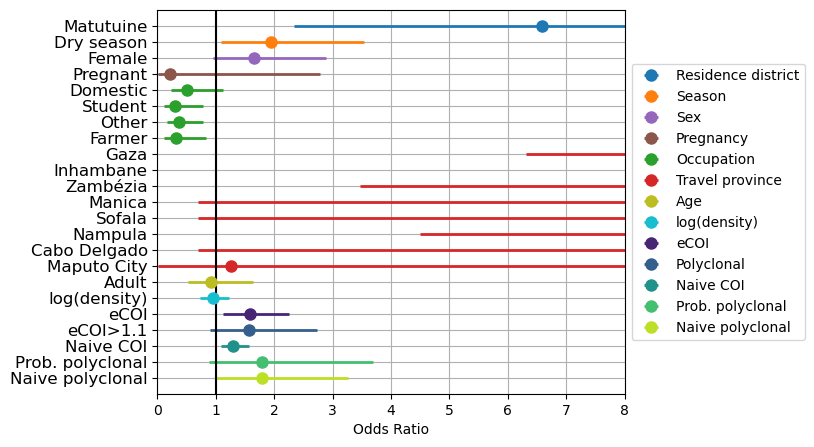

/tmp/ipykernel_30026/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.59 (2.34, 25.22)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_30026/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Matutuine,"6.59 (2.34, 25.22)",0.0001
Dry season,"1.95 (1.08, 3.53)",0.0265
Female,"1.65 (0.95, 2.88)",0.0746
Pregnant,"0.22 (0.0, 2.79)",0.2631
Domestic,"0.5 (0.22, 1.11)",0.0908
Student,"0.3 (0.11, 0.78)",0.0133
Other,"0.36 (0.17, 0.77)",0.0086
Farmer,"0.32 (0.11, 0.83)",0.0193
Gaza,"52.78 (6.31, 943.21)",0.0001
Inhambane,"78.11 (13.68, 865.04)",0.0


In [45]:
#input data
y = 'imported'
factor_list = ['district', 'season', 'sex', 'pregnancy', 'occupation_simp', 
               'travel_prov', 'age_cat', 'logdens', 'eCOI', 'polyclonal', 
               'naive_coi', 'prob_polyclonal', 'naive_polyclonal']
feature_refs = ['Magude', 'rainy', 'Masculino', 'Nao', 'Nao aplicavel', 
               'Maputo', 'Minor', 'none', 'none', 0, 
               'none', 'none', 0]

#Run univariate analysis
all_odds, all_odds_CI, all_p_vals, all_names = make_all_univ_regressions(import_data, factor_list, y, \
                                                                        feature_ref = feature_refs)
all_names = rename_univ_names(all_names)
#Visualise results
plot_univariade_odds(all_odds, all_odds_CI, all_p_vals, all_names, factor_list, \
                    save = False, out_filename = 'odds_univariate_importation_agecat_matutuine', \
                    save_path= save_path, xlim = [0,8], colours = factor2color, \
                    fontsize = 12)
#Make results table
results_table = make_odds_res_table(all_odds, all_odds_CI, all_p_vals, all_names)
results_table

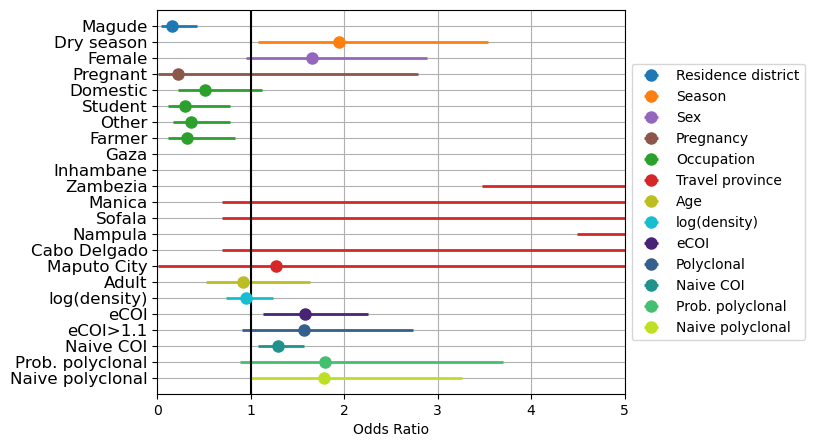

/tmp/ipykernel_37425/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.15 (0.04, 0.43)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_37425/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"0.15 (0.04, 0.43)",0.0001
Dry season,"1.95 (1.08, 3.53)",0.0265
Female,"1.65 (0.95, 2.88)",0.0746
Pregnant,"0.22 (0.0, 2.79)",0.2631
Domestic,"0.5 (0.22, 1.11)",0.0908
Student,"0.3 (0.11, 0.78)",0.0133
Other,"0.36 (0.17, 0.77)",0.0086
Farmer,"0.32 (0.11, 0.83)",0.0193
Gaza,"52.78 (6.31, 943.21)",0.0001
Inhambane,"78.11 (13.68, 865.04)",0.0


In [61]:
#input data
y = 'imported'
factor_list = ['district', 'season', 'sex', 'pregnancy', 'occupation_simp', 
               'travel_prov', 'age_cat', 'logdens', 'eCOI', 'polyclonal', 
               'naive_coi', 'prob_polyclonal', 'naive_polyclonal']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao', 'Nao aplicavel', 
               'Maputo', 'Minor', 'none', 'none', 0, 
               'none', 'none', 0]

#Run univariate analysis
all_odds, all_odds_CI, all_p_vals, all_names = make_all_univ_regressions(import_data, factor_list, y, \
                                                                        feature_ref = feature_refs)
all_names = rename_univ_names(all_names)
#Visualise results
plot_univariade_odds(all_odds, all_odds_CI, all_p_vals, all_names, factor_list, \
                    save = False, out_filename = 'odds_univariate_importation_agecat', \
                    save_path= save_path, xlim = [0,5], colours = factor2color, \
                    fontsize = 12)
#Make results table
results_table = make_odds_res_table(all_odds, all_odds_CI, all_p_vals, all_names)
results_table

#### Risk factor associated to travel

Here we conduct the same analysis but to find association with having travelled instead of being imported

In [46]:
#Transforming travel data to binary
import_data['travel'] = 2 - import_data['travel']

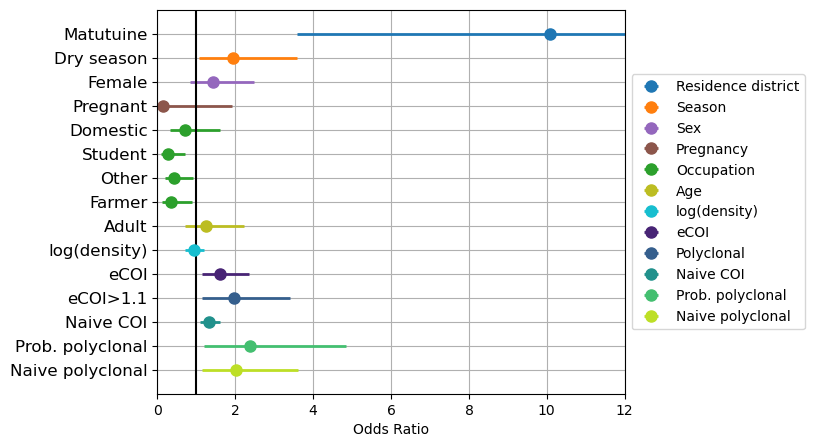

/tmp/ipykernel_30026/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '10.08 (3.57, 38.61)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_30026/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Matutuine,"10.08 (3.57, 38.61)",0.0
Dry season,"1.95 (1.08, 3.58)",0.027
Female,"1.44 (0.84, 2.49)",0.1905
Pregnant,"0.15 (0.0, 1.9)",0.153
Domestic,"0.72 (0.31, 1.62)",0.421
Student,"0.28 (0.1, 0.72)",0.008
Other,"0.43 (0.2, 0.92)",0.0286
Farmer,"0.34 (0.13, 0.9)",0.0289
Adult,"1.26 (0.71, 2.23)",0.4279
log(density),"0.93 (0.72, 1.21)",0.5878


In [52]:
#input data
y = 'travel'
factor_list = ['district', 'season', 'sex', 'pregnancy', 'occupation_simp', 
               'age_cat', 'logdens', 'eCOI', 'polyclonal', 
               'naive_coi', 'prob_polyclonal', 'naive_polyclonal']
feature_refs = ['Magude', 'rainy', 'Masculino', 'Nao', 'Nao aplicavel', 
               'Minor', 'none', 'none', 0, 
               'none', 'none', 0]

#Run univariate analysis
all_odds, all_odds_CI, all_p_vals, all_names = make_all_univ_regressions(import_data, factor_list, y, \
                                                                        feature_ref = feature_refs)
all_names = rename_univ_names(all_names)
#Visualise results
plot_univariade_odds(all_odds, all_odds_CI, all_p_vals, all_names, factor_list, \
                    save = False, out_filename = 'odds_univariate_travel_agecat_matutuine', \
                    save_path= save_path, colours = factor2color, \
                    fontsize = 12, xlim = [0,12])
#Make results table
results_table = make_odds_res_table(all_odds, all_odds_CI, all_p_vals, all_names)
results_table

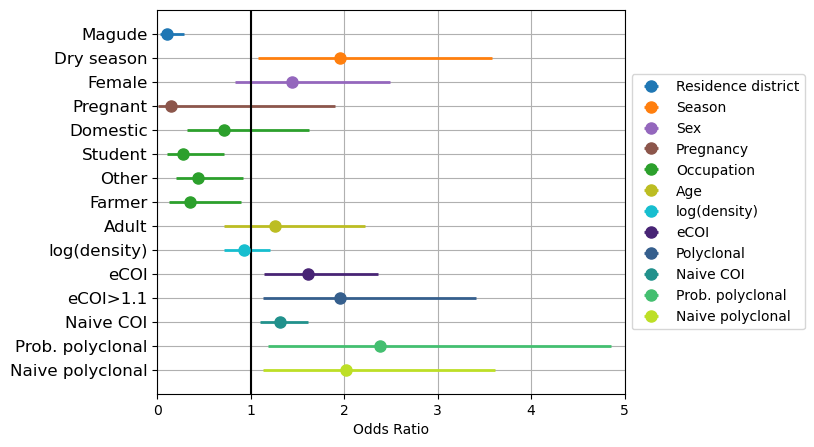

/tmp/ipykernel_37425/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.1 (0.03, 0.28)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_37425/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"0.1 (0.03, 0.28)",0.0
Dry season,"1.95 (1.08, 3.58)",0.027
Female,"1.44 (0.84, 2.49)",0.1905
Pregnant,"0.15 (0.0, 1.9)",0.153
Domestic,"0.72 (0.31, 1.62)",0.421
Student,"0.28 (0.1, 0.72)",0.008
Other,"0.43 (0.2, 0.92)",0.0286
Farmer,"0.34 (0.13, 0.9)",0.0289
Adult,"1.26 (0.71, 2.23)",0.4279
log(density),"0.93 (0.72, 1.21)",0.5878


In [63]:
#input data
y = 'travel'
factor_list = ['district', 'season', 'sex', 'pregnancy', 'occupation_simp', 
               'age_cat', 'logdens', 'eCOI', 'polyclonal', 
               'naive_coi', 'prob_polyclonal', 'naive_polyclonal']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao', 'Nao aplicavel', 
               'Minor', 'none', 'none', 0, 
               'none', 'none', 0]

#Run univariate analysis
all_odds, all_odds_CI, all_p_vals, all_names = make_all_univ_regressions(import_data, factor_list, y, \
                                                                        feature_ref = feature_refs)
all_names = rename_univ_names(all_names)
#Visualise results
plot_univariade_odds(all_odds, all_odds_CI, all_p_vals, all_names, factor_list, \
                    save = True, out_filename = 'odds_univariate_travel_agecat', \
                    save_path= save_path, colours = factor2color, \
                    fontsize = 12)
#Make results table
results_table = make_odds_res_table(all_odds, all_odds_CI, all_p_vals, all_names)
results_table

#### Risk factor associated to importation conditional to travelled

Finally, this analysis finds association of factors to importation, but conditioning the cases to those having reported a travel: 

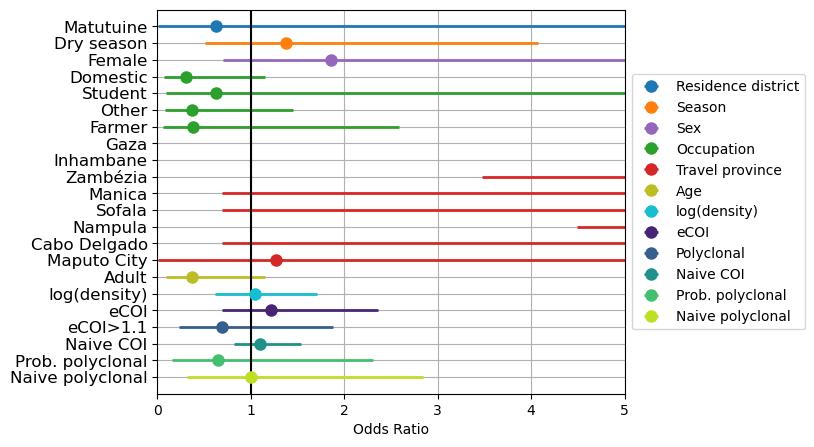

/tmp/ipykernel_30026/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.63 (0.0, 6.86)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_30026/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7472' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Matutuine,"0.63 (0.0, 6.86)",0.7472
Dry season,"1.38 (0.51, 4.08)",0.536
Female,"1.86 (0.7, 5.1)",0.213
Domestic,"0.3 (0.07, 1.15)",0.0806
Student,"0.63 (0.09, 7.13)",0.6672
Other,"0.37 (0.08, 1.45)",0.1527
Farmer,"0.38 (0.06, 2.58)",0.2854
Gaza,"52.78 (6.31, 943.21)",0.0001
Inhambane,"78.11 (13.68, 865.04)",0.0
Zambézia,"22.62 (3.47, 273.98)",0.0006


In [53]:
#input data
y = 'imported'
travel_mask = import_data['travel'] == 1
data = import_data[travel_mask]
factor_list = ['district', 'season', 'sex', 'occupation_simp', 'travel_prov',
               'age_cat', 'logdens', 'eCOI', 'polyclonal', 
               'naive_coi', 'prob_polyclonal', 'naive_polyclonal']
feature_refs = ['Magude', 'rainy', 'Masculino', 'Nao aplicavel', 'Maputo', 
                'Minor', 'none', 'none', 0, 
               'none', 'none', 0]

#Run univariate analysis
all_odds, all_odds_CI, all_p_vals, all_names = make_all_univ_regressions(data, factor_list, y, \
                                                                        feature_ref = feature_refs)
all_names = rename_univ_names(all_names)
#Visualise results
plot_univariade_odds(all_odds, all_odds_CI, all_p_vals, all_names, factor_list, \
                    save = True, out_filename = 'odds_univariate_imp_travelled_agecat_matutuine', \
                    save_path= save_path, colours = factor2color, xlim = [0,5], \
                    fontsize = 12)
#Make results table
results_table = make_odds_res_table(all_odds, all_odds_CI, all_p_vals, all_names)
results_table

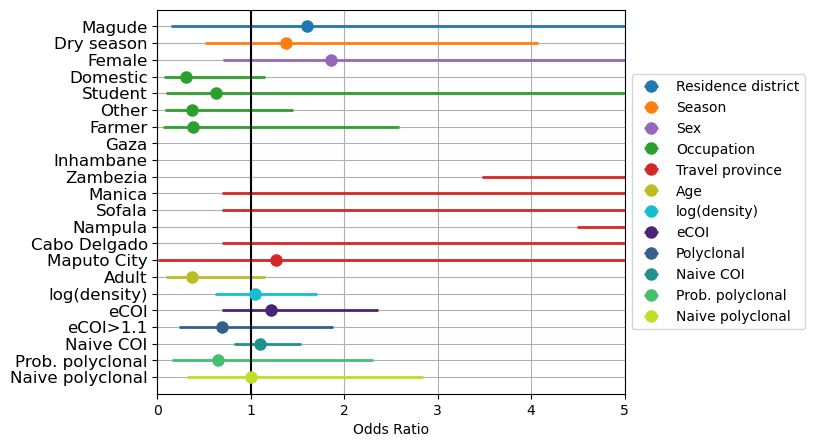

/tmp/ipykernel_37425/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.6 (0.15, 218.01)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_37425/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7472' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"1.6 (0.15, 218.01)",0.7472
Dry season,"1.38 (0.51, 4.08)",0.536
Female,"1.86 (0.7, 5.1)",0.213
Domestic,"0.3 (0.07, 1.15)",0.0806
Student,"0.63 (0.09, 7.13)",0.6672
Other,"0.37 (0.08, 1.45)",0.1527
Farmer,"0.38 (0.06, 2.58)",0.2854
Gaza,"52.78 (6.31, 943.21)",0.0001
Inhambane,"78.11 (13.68, 865.04)",0.0
Zambezia,"22.62 (3.47, 273.98)",0.0006


In [64]:
#input data
y = 'imported'
travel_mask = import_data['travel'] == 1
data = import_data[travel_mask]
factor_list = ['district', 'season', 'sex', 'occupation_simp', 'travel_prov',
               'age_cat', 'logdens', 'eCOI', 'polyclonal', 
               'naive_coi', 'prob_polyclonal', 'naive_polyclonal']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao aplicavel', 'Maputo', 
                'Minor', 'none', 'none', 0, 
               'none', 'none', 0]

#Run univariate analysis
all_odds, all_odds_CI, all_p_vals, all_names = make_all_univ_regressions(data, factor_list, y, \
                                                                        feature_ref = feature_refs)
all_names = rename_univ_names(all_names)
#Visualise results
plot_univariade_odds(all_odds, all_odds_CI, all_p_vals, all_names, factor_list, \
                    save = True, out_filename = 'odds_univariate_imp_travelled_agecat', \
                    save_path= save_path, colours = factor2color, xlim = [0,5], \
                    fontsize = 12)
#Make results table
results_table = make_odds_res_table(all_odds, all_odds_CI, all_p_vals, all_names)
results_table

### Mutivariate firth logistic regression

To end the study, multivariate analyses have been conducted with all factors included in the Firth's logistic regressions. 

This first script corresponds to the multivariate analysis to find association with importation: 

Reference value: Magude
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
Reference value: Minor
                 coef    std err     [0.025      0.975]     p-value
----------  ---------  ---------  ---------  ----------  ----------
Matutuine    1.50052    0.606981   0.432355   2.85726    0.00447906
dry          0.44126    0.323688  -0.181305   1.06731    0.158888
Feminino     0.422952   0.330008  -0.212419   1.06466    0.191695
Domestica   -1.02632    0.564742  -2.13982    0.0411152  0.0595848
Estudante   -0.815942   0.552669  -1.90586    0.230182   0.123593
Other       -0.853093   0.507485  -1.85983    0.103517   0.0808274
Agricultor  -1.11411    0.636553  -2.37384    0.0814758  0.0680263
Adult        0.44746    0.457174  -0.410717   1.35735    0.310569
Intercept   -1.58598    0.698459  -3.08561   -0.321979   0.0126484

Log-Likelihood: -119.1669
Newton-Raphson iterations: 5

odds ratio: [4.48400993 1.55466513 1.52646153 0.35832307 0.4422226  0.42609478


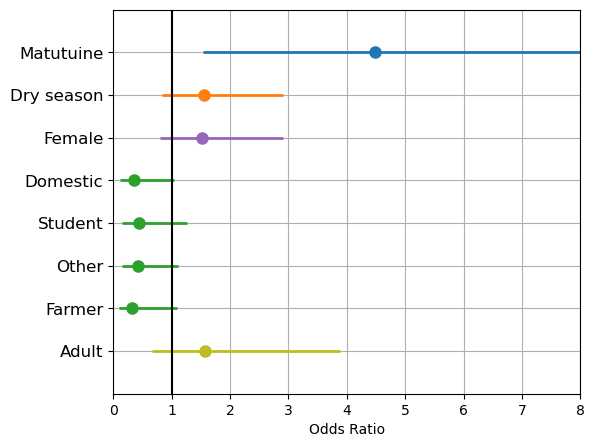

/tmp/ipykernel_30026/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '4.48 (1.54, 17.41)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_30026/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0045' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Matutuine,"4.48 (1.54, 17.41)",0.0045
Dry season,"1.55 (0.83, 2.91)",0.1589
Female,"1.53 (0.81, 2.9)",0.1917
Domestic,"0.36 (0.12, 1.04)",0.0596
Student,"0.44 (0.15, 1.26)",0.1236
Other,"0.43 (0.16, 1.11)",0.0808
Farmer,"0.33 (0.09, 1.08)",0.068
Adult,"1.56 (0.66, 3.89)",0.3106


In [61]:
#input data
y = "imported"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age_cat']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'categ']
feature_refs = ['Magude', 'rainy', 'Masculino', 'Nao aplicavel', 'Minor']
fontsize = 12
data = import_data

#Run multivariate analysis
odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Matutuine', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Adult']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive']

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,8)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio) - 1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_import_agecat_matutuine.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_import_agecat_matutuine.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table

Reference value: Matutuine
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
Reference value: Minor
                  coef    std err     [0.025      0.975]     p-value
----------  ----------  ---------  ---------  ----------  ----------
Magude      -1.50052     0.606981  -2.85726   -0.432355   0.00447906
dry          0.44126     0.323688  -0.181305   1.06731    0.158917
Feminino     0.422952    0.330008  -0.212419   1.06466    0.19169
Domestica   -1.02632     0.564742  -2.13982    0.0411152  0.0595842
Estudante   -0.815942    0.552669  -1.90586    0.230182   0.123696
Other       -0.853093    0.507485  -1.85983    0.103517   0.0808266
Agricultor  -1.11411     0.636553  -2.37384    0.0814758  0.0680259
Adult        0.44746     0.457174  -0.410717   1.35735    0.310554
Intercept   -0.0854624   0.397457  -0.853904   0.683872   0.82558

Log-Likelihood: -119.1669
Newton-Raphson iterations: 5

odds ratio: [0.22301467 1.55466513 1.52646153 0.35832307 0.4422226  

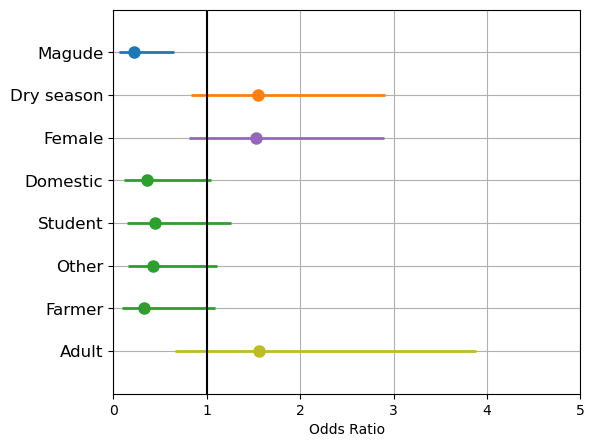

/tmp/ipykernel_30026/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.22 (0.06, 0.65)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_30026/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0045' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"0.22 (0.06, 0.65)",0.0045
Dry season,"1.55 (0.83, 2.91)",0.1589
Female,"1.53 (0.81, 2.9)",0.1917
Domestic,"0.36 (0.12, 1.04)",0.0596
Student,"0.44 (0.15, 1.26)",0.1237
Other,"0.43 (0.16, 1.11)",0.0808
Farmer,"0.33 (0.09, 1.08)",0.068
Adult,"1.56 (0.66, 3.89)",0.3106


In [57]:
#input data
y = "imported"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age_cat']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'categ']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao aplicavel', 'Minor']
fontsize = 12
data = import_data

#Run multivariate analysis
odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Magude', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Adult']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive']

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,5)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio) - 1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_import_agecat.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_import_agecat.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table

This multivariate analysis quantifies the associations with having travelled: 

Reference value: Magude
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
Reference value: Minor
                 coef    std err     [0.025      0.975]      p-value
----------  ---------  ---------  ---------  ----------  -----------
Matutuine    1.9402     0.605543   0.876902   3.2942     0.000144625
dry          0.392723   0.330411  -0.24023    1.03648    0.218488
Feminino     0.196634   0.33224   -0.447049   0.838963   0.547014
Domestica   -0.73947    0.58214   -1.89339    0.360856   0.189601
Estudante   -0.809032   0.555779  -1.89733    0.251052   0.130843
Other       -0.819993   0.52062   -1.8615     0.156806   0.100806
Agricultor  -1.22763    0.641761  -2.50009   -0.0215984  0.0459597
Adult        0.64254    0.46491   -0.22652    1.57466    0.149397
Intercept   -1.65524    0.702617  -3.16047   -0.379869   0.00982164

Log-Likelihood: -117.9363
Newton-Raphson iterations: 5

odds ratio: [6.96017341 1.48100829 1.21729824 0.4773669  0.44528878 0.4404345

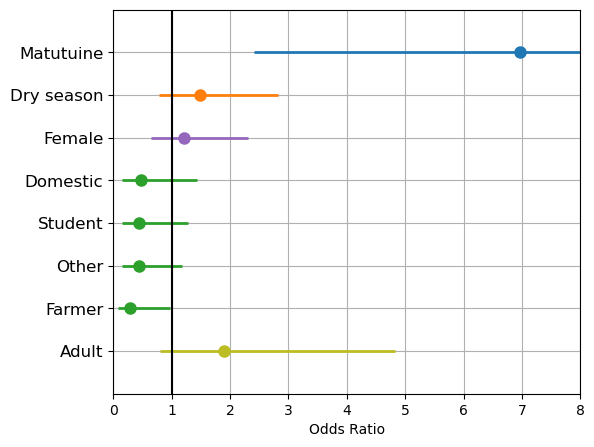

/tmp/ipykernel_30026/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '6.96 (2.4, 26.96)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_30026/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Matutuine,"6.96 (2.4, 26.96)",0.0001
Dry season,"1.48 (0.79, 2.82)",0.2185
Female,"1.22 (0.64, 2.31)",0.547
Domestic,"0.48 (0.15, 1.43)",0.1896
Student,"0.45 (0.15, 1.29)",0.1308
Other,"0.44 (0.16, 1.17)",0.1008
Farmer,"0.29 (0.08, 0.98)",0.046
Adult,"1.9 (0.8, 4.83)",0.1494


In [60]:
#Input data
y = "travel"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age_cat']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'categ']
feature_refs = ['Magude', 'rainy', 'Masculino', 'Nao aplicavel', 'Minor']
fontsize = 12
data = import_data

#Run multivarite analysis
odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Matutuine', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Adult']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive']

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,8)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio) - 1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_travel_agecat_matutuine.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_travel_agecat_matutuine.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table

Reference value: Matutuine
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
Reference value: Minor
                 coef    std err     [0.025      0.975]      p-value
----------  ---------  ---------  ---------  ----------  -----------
Magude      -1.9402     0.605543  -3.2942    -0.876902   0.000144625
dry          0.392723   0.330411  -0.24023    1.03648    0.218513
Feminino     0.196634   0.33224   -0.447049   0.838963   0.546976
Domestica   -0.73947    0.58214   -1.89339    0.360856   0.189597
Estudante   -0.809032   0.555779  -1.89733    0.251052   0.130974
Other       -0.819993   0.52062   -1.8615     0.156806   0.100804
Agricultor  -1.22763    0.641761  -2.50009   -0.0215984  0.0459595
Adult        0.64254    0.46491   -0.22652    1.57466    0.149393
Intercept    0.284967   0.404584  -0.488957   1.07839    0.47116

Log-Likelihood: -117.9363
Newton-Raphson iterations: 5

odds ratio: [0.14367458 1.48100829 1.21729824 0.4773669  0.44528878 0.4404345

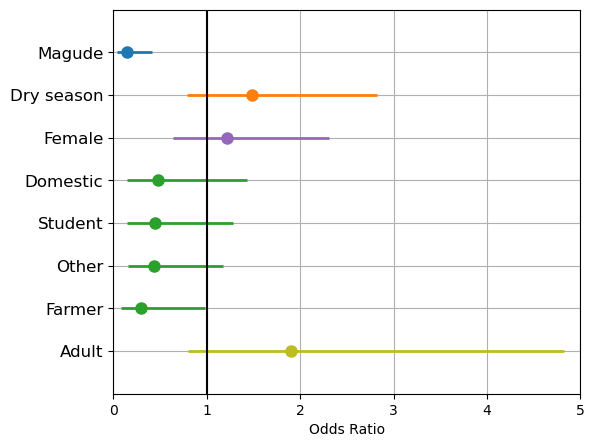

/tmp/ipykernel_37425/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.14 (0.04, 0.42)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_37425/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.0001' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"0.14 (0.04, 0.42)",0.0001
Dry season,"1.48 (0.79, 2.82)",0.2185
Female,"1.22 (0.64, 2.31)",0.547
Domestic,"0.48 (0.15, 1.43)",0.1896
Student,"0.45 (0.15, 1.29)",0.131
Other,"0.44 (0.16, 1.17)",0.1008
Farmer,"0.29 (0.08, 0.98)",0.046
Adult,"1.9 (0.8, 4.83)",0.1494


In [66]:
#Input data
y = "travel"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age_cat']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'categ']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao aplicavel', 'Minor']
fontsize = 12
data = import_data

#Run multivarite analysis
odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Magude', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Adult']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive']

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,5)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio) - 1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_travel_agecat.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_travel_agecat.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table

This script conducts the multivariate analysis on importation conditional to having travelled, without including the factor of travel destination: 

Reference value: Magude
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
Reference value: Minor
                 coef    std err     [0.025    0.975]    p-value
----------  ---------  ---------  ---------  --------  ---------
Matutuine   -0.476713   1.91353   -5.5808    2.42086    0.715195
dry          0.323944   0.549498  -0.717378  1.45861    0.507837
Feminino     0.857766   0.572456  -0.23916   2.03333    0.125348
Domestica   -0.92515    1.07706   -3.33695   0.925965   0.340026
Estudante   -0.619673   1.09022   -2.64282   1.8338     0.547386
Other       -0.217063   1.08789   -2.6503    1.68211    0.783753
Agricultor  -0.174529   1.24472   -2.78471   2.13991    0.798981
Adult       -0.416578   1.09099   -2.38266   2.00726    0.67511
Intercept    1.98625    1.93589   -0.939255  7.12818    0.198409

Log-Likelihood: -43.8478
Newton-Raphson iterations: 9

odds ratio: [0.62082063 1.38256971 2.35788725 0.39647206 0.53812058 0.80487917
 0.8398528  0.65929912]

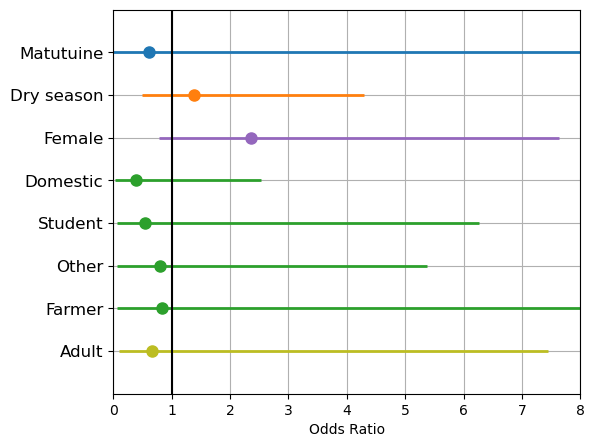

/tmp/ipykernel_30026/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.62 (0.0, 11.26)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_30026/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.7152' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Matutuine,"0.62 (0.0, 11.26)",0.7152
Dry season,"1.38 (0.49, 4.3)",0.5078
Female,"2.36 (0.79, 7.64)",0.1253
Domestic,"0.4 (0.04, 2.52)",0.34
Student,"0.54 (0.07, 6.26)",0.5474
Other,"0.8 (0.07, 5.38)",0.7838
Farmer,"0.84 (0.06, 8.5)",0.799
Adult,"0.66 (0.09, 7.44)",0.6751


In [63]:
#Conditional to travel
#Input data
y = "imported"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age_cat']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'categ']
feature_refs = ['Magude', 'rainy', 'Masculino', 'Nao aplicavel', 'Minor']
fontsize = 12

data = import_data[import_data['travel_prov'].notnull()]

#Run multivariate analysis
odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Matutuine', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Adult']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive']

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,8)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio) - 1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled_agecat_matutuine.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled_agecat_matutuine.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table

Reference value: Matutuine
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
Reference value: Minor
                 coef    std err     [0.025    0.975]    p-value
----------  ---------  ---------  ---------  --------  ---------
Magude       0.476713   1.91353   -2.42086   5.5808    0.715195
dry          0.323944   0.549498  -0.717378  1.45861   0.507345
Feminino     0.857766   0.572456  -0.23916   2.03333   0.125345
Domestica   -0.92515    1.07706   -3.33695   0.925965  0.340085
Estudante   -0.619673   1.09022   -2.64282   1.8338    0.547418
Other       -0.217063   1.08789   -2.6503    1.68211   0.781903
Agricultor  -0.174529   1.24472   -2.78471   2.13991   0.799999
Adult       -0.416578   1.09099   -2.38266   2.00726   0.674413
Intercept    1.50953    0.745962   0.136404  3.1067    0.0304565

Log-Likelihood: -43.8478
Newton-Raphson iterations: 9

odds ratio: [1.61077122 1.38256971 2.35788725 0.39647206 0.53812058 0.80487917
 0.8398528  0.65929912]
odd

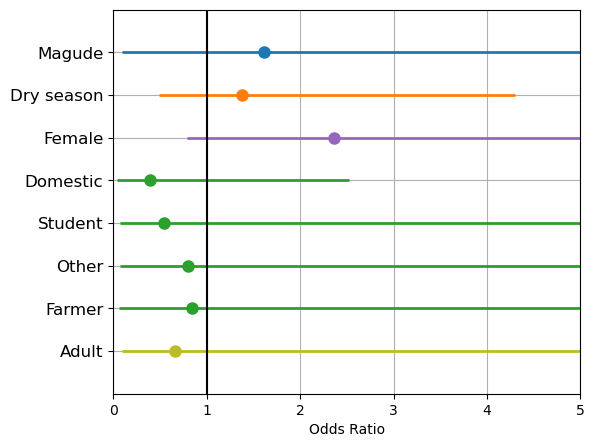

/tmp/ipykernel_37425/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.61 (0.09, 265.28)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_37425/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.7152' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"1.61 (0.09, 265.28)",0.7152
Dry season,"1.38 (0.49, 4.3)",0.5073
Female,"2.36 (0.79, 7.64)",0.1253
Domestic,"0.4 (0.04, 2.52)",0.3401
Student,"0.54 (0.07, 6.26)",0.5474
Other,"0.8 (0.07, 5.38)",0.7819
Farmer,"0.84 (0.06, 8.5)",0.8
Adult,"0.66 (0.09, 7.44)",0.6744


In [67]:
#Conditional to travel
#Input data
y = "imported"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age_cat']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'categ']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao aplicavel', 'Minor']
fontsize = 12

data = import_data[import_data['travel_prov'].notnull()]

#Run multivariate analysis
odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Magude', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Adult']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive']

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,5)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio) - 1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled_agecat.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled_agecat.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table

And this time, we also include the factor of travel destination in the multivariate analysis: 

Reference value: Magude
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
Reference value: Minor
Reference value: Maputo
                    coef    std err     [0.025    0.975]      p-value
------------  ----------  ---------  ---------  --------  -----------
Matutuine      0.84363     2.05846   -4.94132    4.27233  0.593162
dry            0.0266578   0.730439  -1.434      1.62588  0.753282
Feminino       1.05546     0.725319  -0.393212   2.66932  0.144753
Domestica      0.113424    1.15591   -2.40878    2.2235   0.718006
Estudante     -0.114613    1.43418   -3.09047    3.57545  0.794705
Other          1.00825     1.21532   -1.5668     3.38151  0.373377
Agricultor     1.20734     1.47053   -1.70945    4.24557  0.371259
Adult         -1.6805      1.26392   -4.30365    1.02185  0.199156
Gaza           3.73171     1.32664    1.41991    6.75934  0.000804157
Inhambane      4.11555     1.09344    2.26235    6.63559  1.60774e-06
Zambezia       2.64647     1.256

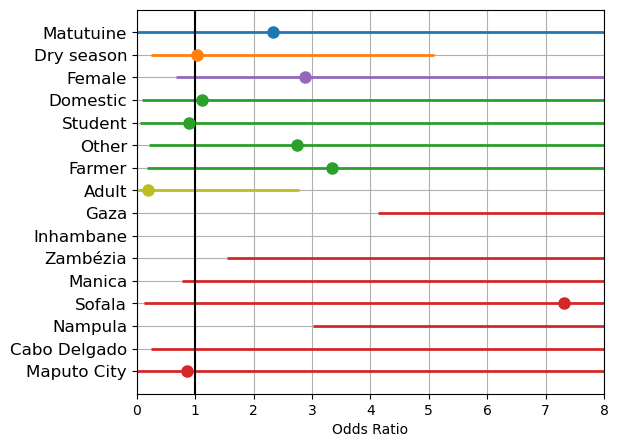

/tmp/ipykernel_30026/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '2.32 (0.01, 71.69)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_30026/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0.5932' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Matutuine,"2.32 (0.01, 71.69)",0.5932
Dry season,"1.03 (0.24, 5.08)",0.7533
Female,"2.87 (0.67, 14.43)",0.1448
Domestic,"1.12 (0.09, 9.24)",0.718
Student,"0.89 (0.05, 35.71)",0.7947
Other,"2.74 (0.21, 29.42)",0.3734
Farmer,"3.34 (0.18, 69.8)",0.3713
Adult,"0.19 (0.01, 2.78)",0.1992
Gaza,"41.75 (4.14, 862.08)",0.0008
Inhambane,"61.29 (9.61, 761.73)",0.0


In [65]:
#Conditional to travel
#Input data
y = "imported"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age_cat', 'travel_prov']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'categ', 'categ']
feature_refs = ['Magude', 'rainy', 'Masculino', 'Nao aplicavel', 'Minor', 'Maputo']
fontsize = 12

data = import_data[import_data['travel_prov'].notnull()]

#Run multivariate analysis
odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Matutuine', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Adult', 'Gaza',
 'Inhambane',
 'Zambézia',
 'Manica',
 'Sofala',
 'Nampula',
 'Cabo Delgado',
 'Maputo City']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive', \
          'tab:red', 'tab:red', 'tab:red', 'tab:red', 'tab:red', \
           'tab:red', 'tab:red', 'tab:red', ]

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,8)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio)-1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled_travprov_agecat_matutuine.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled_travprov_agecat_matutuine.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table

Reference value: Matutuine
Reference value: rainy
Reference value: Masculino
Reference value: Nao aplicavel
Reference value: Minor
Reference value: Maputo
                    coef    std err     [0.025    0.975]      p-value
------------  ----------  ---------  ---------  --------  -----------
Magude        -0.84363     2.05846   -4.27233   4.94132   0.593162
dry            0.0266578   0.730439  -1.434     1.62588   0.751165
Feminino       1.05546     0.725319  -0.393212  2.66932   0.144498
Domestica      0.113424    1.15591   -2.40878   2.2235    0.717316
Estudante     -0.114613    1.43418   -3.09047   3.57545   0.792487
Other          1.00825     1.21532   -1.5668    3.38151   0.372287
Agricultor     1.20734     1.47053   -1.70945   4.24557   0.371444
Adult         -1.6805      1.26392   -4.30365   1.02185   0.198922
Gaza           3.73171     1.32664    1.41991   6.75934   0.000804106
Inhambane      4.11555     1.09344    2.26235   6.63559   1.60809e-06
Zambezia       2.64647     1.

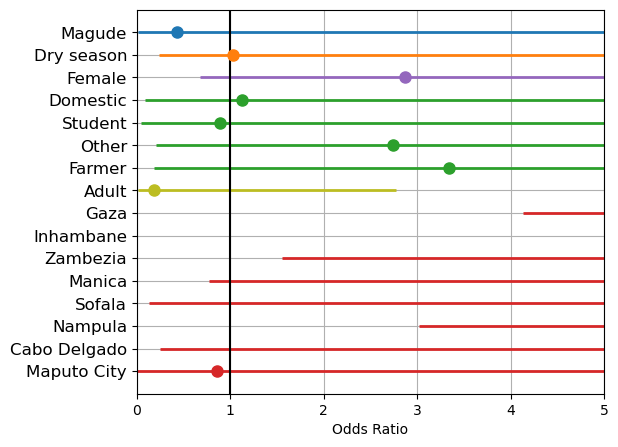

/tmp/ipykernel_37425/3569712257.py:27: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.43 (0.01, 139.95)' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "Odds ratio (95%CI)"] = str(round(all_odds[factor][j], 2)) + " (" + \
/tmp/ipykernel_37425/3569712257.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5932' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  results_table.loc[name, "P-value"] = str(round(all_p_vals[factor][j], 4))


,Odds ratio (95%CI),P-value
Magude,"0.43 (0.01, 139.95)",0.5932
Dry season,"1.03 (0.24, 5.08)",0.7512
Female,"2.87 (0.67, 14.43)",0.1445
Domestic,"1.12 (0.09, 9.24)",0.7173
Student,"0.89 (0.05, 35.71)",0.7925
Other,"2.74 (0.21, 29.42)",0.3723
Farmer,"3.34 (0.18, 69.8)",0.3714
Adult,"0.19 (0.01, 2.78)",0.1989
Gaza,"41.75 (4.14, 862.08)",0.0008
Inhambane,"61.29 (9.61, 761.73)",0.0


In [68]:
#Conditional to travel
#Input data
y = "imported"
factor_list_multi = ['district', 'season', 'sex', 'occupation_simp', 'age_cat', 'travel_prov']
dtypes_list = ['categ', 'categ', 'categ', 'categ', 'categ', 'categ']
feature_refs = ['Matutuine', 'rainy', 'Masculino', 'Nao aplicavel', 'Minor', 'Maputo']
fontsize = 12

data = import_data[import_data['travel_prov'].notnull()]

#Run multivariate analysis
odds_ratio, odds_ci, p_vals, feature_names = firth_logist_reg(data, factor_list_multi, y, \
                                                                  data_type = dtypes_list, \
                                                                  verbose = True, clean_data = False, \
                                                             feature_ref = feature_refs)

feature_names = ['Magude', 'Dry season', 'Female',
 'Domestic', 'Student', 'Other', 'Farmer', 'Adult', 'Gaza',
 'Inhambane',
 'Zambézia',
 'Manica',
 'Sofala',
 'Nampula',
 'Cabo Delgado',
 'Maputo City']

#Visualise results
colours = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', \
          'tab:green', 'tab:green', 'tab:green', 'tab:olive', \
          'tab:red', 'tab:red', 'tab:red', 'tab:red', 'tab:red', \
           'tab:red', 'tab:red', 'tab:red', ]

ax = plt.subplot(111)
ax.grid()
err_top = odds_ci[:,1] - odds_ratio
err_bot = odds_ratio - odds_ci[:,0]
for i, odd in enumerate(odds_ratio):
    ax.errorbar(odd, -i - 1, xerr = [[err_bot[i]],[err_top[i]]], marker = 'o', markersize = 8, \
                label = feature_names[i], lw = 2, linestyle = 'none', color = colours[i])
yticks = feature_names
ax.set_xlabel("Odds Ratio")
ax.set_yticks(np.linspace(-len(odds_ratio), -1, len(odds_ratio)), yticks[::-1], fontsize = fontsize)
ax.set_xlim(0,5)
ax.set_ylim(-len(odds_ratio) -1, 0)
#factor_for_legend = get_legend_factors(factor_list)
#ax.legend(factor_for_legend, loc='center left', bbox_to_anchor=(1, 0.5))
ax.vlines(1, -len(odds_ratio)-1, 0, color = 'k')
plt.subplots_adjust(left=0.26, right=0.99, top=0.9, bottom=0.1)
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled_travprov_agecat.pdf")
plt.savefig(save_path + "odds_ratio_multivariate_imp_travelled_travprov_agecat.png")
plt.show()


#Make results table
odds_ratio = {'all' : np.array(odds_ratio)}
odds_ci = {'all' : np.array(odds_ci)}
p_vals = {'all' : np.array(p_vals)}
feature_names = {'all' : np.array(feature_names)}
results_table = make_odds_res_table(odds_ratio, odds_ci, p_vals, feature_names)
results_table